In [1]:
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

- The following study presents a model for generating chest X-ray images of normal subjects (without lung disease) and pneumonia patients.
- Through the proposed model, I tried to avoid most of the problems that the GAN models suffer from, in terms of the difficulty of training each of the generator and the discriminant, in addition to the problem of the modal collapse and the perceptual quality, so that I tried through the proposed model, to try to continue the training (to ensure the continuity of the derivability of cost function ) and discovering the features by the discriminator (the most accurate features for each case of the dataset), which leads the generator to focus on them during the training process.
- A conditional model was used for the GAN, and the discriminator was forced to determine whether the medical images are real or not, in addition to identifying the pathological condition in the generated images.
- I used (64, 64, 3) images because I didn't have enough computational resources.
- I used Google Colab For Training.
- Reading the images included in the dataset, which is for the sound health condition, and the other case, which is pneumonia.
- I have included all medical images included in each class, although the number of samples per class varies (thus this would require training for a higher number of Epochs for the GAN).

In [2]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img))
                img = cv2.resize(img , self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img  = img/255
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [3]:
readDatasetObject = ReadDataset(r'C:\Users\bishn\Desktop\Model 3\train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [4]:
images.shape, labels.shape

((2510, 64, 64, 3), (2510,))

Sample images included in the dataset for each class

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


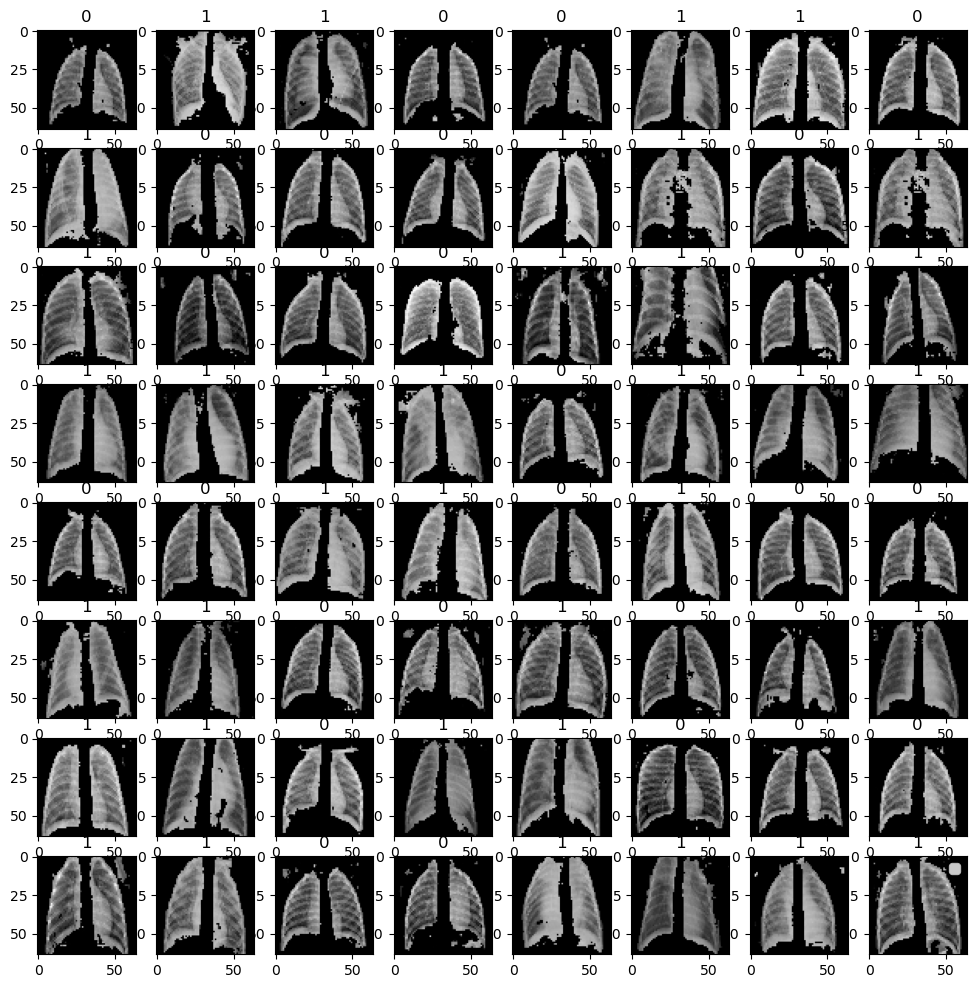

In [5]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

- The proposed generative adversarial network, so that the difficulty of training and many of the problems that can be encountered in the generative adversarial network can be avoided, such as postural collapse and cognitive quality.

- The structure focused on including many structures that helped some of them to avoid falling into the problem of situational collapse, and the other structures focused on perceptual quality (as it forced the distinguished network to focus more on the deeper features in the medical images, which helped the generator to capture them in the generation process).

- The architecture helped make the training balanced between both the Generator and the Discriminator.

- Conditional generation was used, whereby the Discriminator was forced to verify that the generated images were real, class-following (a healthy person, or a person with pneumonia).

- The generator's input was a noise with a regular distribution, in addition to the pathological condition that we want to classify.
- Use the MSE loss function to address the problem of cognitive quality and make the generator focus on the health characteristics of a healthy person, and the pathological characteristics of a person suffering from pneumonia.

In [6]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

- In order to avoid falling into the problem of mode collapse, a smaller number of samples was used to be passed each time to the generative adversarial network.
- It helped reduce the number of samples that are passed to the obstetric adversarial network, until the generator collects more accurately the areas that affect the presence of pneumonia in the patient, as well as the healthy condition.

- Because I didn't have much computational resources, not many Epochs were used.

- Since we are dealing with a pathological condition, the use of kernel_size in a larger size helps to study the relationship between the core regions and the surrounding areas, and the possibility of the existence of gradients that express the pathological condition or the healthy condition. (That is, it helps to determine whether an area, according to its location, can be suitable as a criterion for the presence of pneumonia, or not).
- Using LayerNormalization instead of BatchNormalization was very useful in diversifying the images that the generator generates and not falling into mode collapse (since LayerNormalization does the normalization at the level of the filters included in the layer).

In [7]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 20, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [8]:
acgan.data(images, labels)

In [9]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   51264       ['leaky_re_lu[0][0]']            
                                                                                      

                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (None, 64, 64, 3)   2403        ['conv2d_transpose_3[0][0]']     
 spose)                                                                                           
                                                                                                  
 activation_4 (Activation)      (None, 64, 64, 3)    0           ['conv2d_transpose_4[0][0]']     
                                                                                                  
Total params: 19,616,963
Trainable params: 19,616,963
Non-trainable params: 0
__________________________________________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputL

Epoch: 0
discriminator loss: [tag: 0.5212700366973877, labels: 0.6936084032058716], generator loss: [tag: 0.6440178155899048, labels: 0.6830704212188721]
1/1 [==============================] - 0s 15ms/step


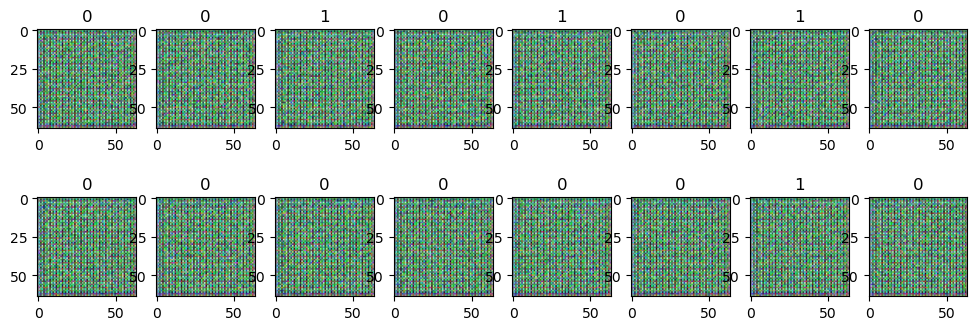

In [10]:
acgan.trainAlgorithm(G, D, GAN)

In [11]:
# G.save(r"C:\Users\bishn\Desktop\Model 3\generator.h5")

In [12]:
# G = tf.keras.models.load_model(r'C:\Users\bishn\Desktop\Model 3\generator.h5')

- We have to make sure that the images that the generator generates are correct, and that they actually include pathological conditions, and this is done by generating a large number of samples, using a neural network to classify the images, and then using the trained neural network, in order to classify the basic images that are included in the basic dataset.

In [13]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [14]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [15]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1], dtype=int64), array([14983, 15017], dtype=int64))

In [16]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 22s 23ms/step


(30000, 64, 64, 3)

- Samples generated by the generator for each case (healthy person, person with pneumonia).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


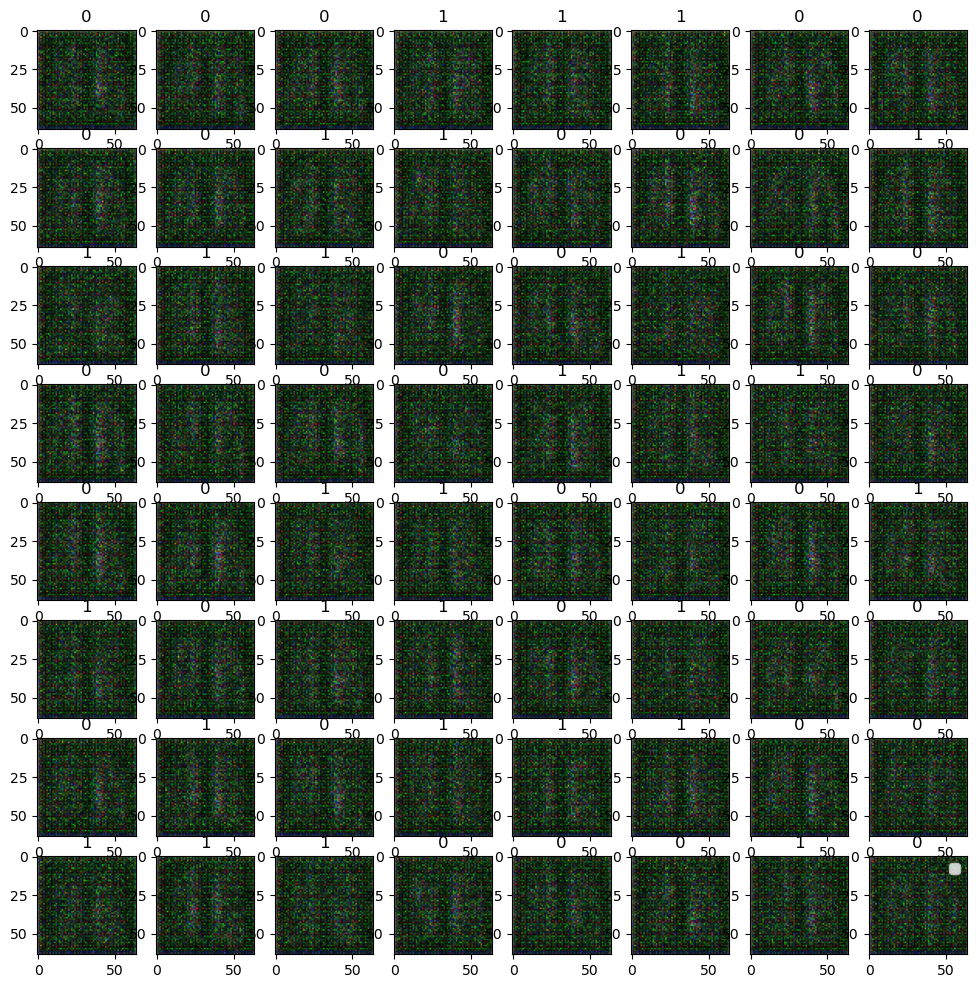

In [17]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i])
    plt.title(t[i])
plt.legend()

In order to be able to evaluate the images generated by the generating neural network, we can do so by proposing a neural structure dedicated to classifying the images generated by the generating neural network, and then we return to the basic images included in the dataset, and we evaluate the performance of the classified neural network that It was trained on the generated images, in order to see if the learned characteristics of the generated images can give high results on the basic images included in the dataset.

In [18]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 3),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

- Training the neural network to classify the images generated by the generator.

In [19]:
model_file = os.path.join(r"C:\Users\bishn\Desktop\Model 3\training_model.h5") 

In [20]:
# callbacks = [
#     ModelCheckpoint(model_file, verbose=1, save_best_only=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 4),
# #     CSVLogger(log_file),
#     EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
# 

In [21]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
#                 callbacks = callbacks)
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 40s 92ms/step - loss: 0.4036 - val_loss: 0.5668
Epoch 2/60
375/375 [==============================] - 34s 90ms/step - loss: 0.1231 - val_loss: 0.0988
Epoch 3/60
375/375 [==============================] - 34s 90ms/step - loss: 0.0801 - val_loss: 0.0577
Epoch 4/60
375/375 [==============================] - 34s 90ms/step - loss: 0.0584 - val_loss: 0.0406
Epoch 5/60
375/375 [==============================] - 34s 90ms/step - loss: 0.0503 - val_loss: 0.0265
Epoch 6/60
375/375 [==============================] - 34s 90ms/step - loss: 0.0441 - val_loss: 0.0231
Epoch 7/60
375/375 [==============================] - 34s 91ms/step - loss: 0.0390 - val_loss: 0.0226
Epoch 8/60
375/375 [==============================] - 34s 90ms/step - loss: 0.0348 - val_loss: 0.0189
Epoch 9/60
375/375 [==============================] - 34s 91ms/step - loss: 0.0317 - val_loss: 0.0188
Epoch 10/60
375/375 [==============================] - 34s 90ms/step - loss: 0.029

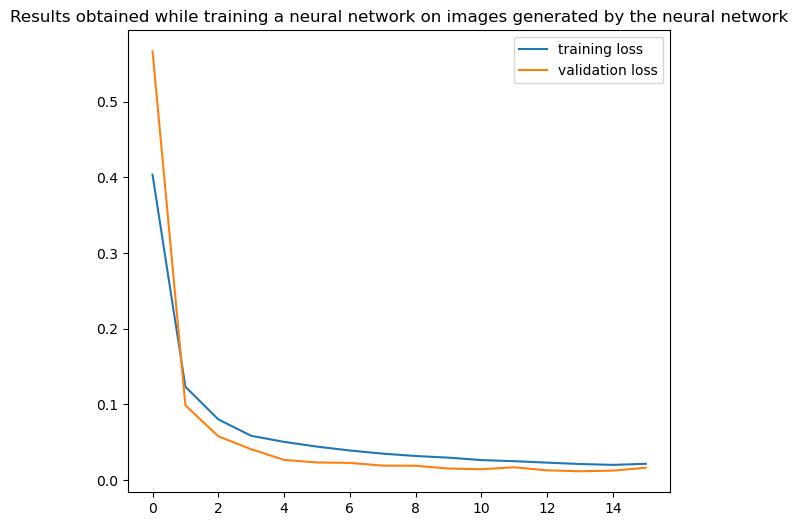

In [22]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

- Now, after training on the images generated by the generator, we will test the neural network on the basic images included in the dataset.

- We will use several measures in the evaluation to study what is the ability of the generative adversarial network to capture the basic features that characterize each class, and whether the second classified network extracted the features included in the generated images.
- Are the attributes that were extracted from the images generated by the generator, can be used on the original images included in the dataset.
- This helps in the ability to study what was actually generated, and whether the focus was really on the cases that the X-ray images made him have pneumonia or not.

In [23]:
m.evaluate(images, labels)

79/79 [==============================] - 4s 28ms/step - loss: 1.7151


1.7151442766189575

In [24]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

79/79 [==============================] - 2s 18ms/step


TensorShape([2510])

In [25]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 1, ..., 1, 1, 1])

In [26]:
accuracy_score(y_pred, labels)*100

61.27490039840637

In [27]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.26      0.88      0.40       375
           1       0.96      0.57      0.71      2135

    accuracy                           0.61      2510
   macro avg       0.61      0.72      0.56      2510
weighted avg       0.86      0.61      0.67      2510



In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[ 329,   46],
       [ 926, 1209]], dtype=int64)

In [29]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,329,46
PNEUMONIA,926,1209


In [30]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 71.32743362831859, recall_score: 56.62763466042154, precision_score: 96.33466135458167


In [31]:
# m.save(r"C:\Users\bishn\Desktop\Model 3\final_model.h5")

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\bishn\Desktop\Model 3\final_model.h5")  # replace with your model path

In [33]:

# Load an image for prediction
img_path = r"C:\Users\bishn\Desktop\Model 3\test\NORMAL\NORMAL (92).jpeg"  # Normal Image
# img_path = r"C:\Users\bishn\Desktop\Model 3\test\PNEUMONIA\PNEUMONIA (73).jpeg"  # Pneumonia Image
img = load_img(img_path, target_size=(64, 64))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.  # Model was trained with inputs being normalized to the range [0., 1.]

# Predict the class of the image
pred = m.predict(img_tensor)
preds = model.predict(img_tensor)
predicted_class = np.argmax(preds)
print("Saved Model=",preds)
if preds >= 0.5:
    print('The model predicts that the image is of a Pneumonia condition.')
else:
    print('The model predicts that the image is of a Normal condition.')
print("Training predictions=",pred)   
if pred >= 0.5:
    print('The model predicts that the image is of a Pneumonia condition.')
else:
    print('The model predicts that the image is of a Normal condition.')


1/1 [==============================] - 0s 138ms/step
Saved Model= [[0.23322316]]
The model predicts that the image is of a Normal condition.
Training predictions= [[0.9986733]]
The model predicts that the image is of a Pneumonia condition.
